In [ ]:
#| default_exp predtrend

In [ ]:
import importlib

In [ ]:
#| export 
from fcst_action.core import *
from fcst_action.utils import *

In [ ]:
#| export
from pytrends.request import TrendReq
import time
import requests
from datetime import datetime as dt
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
from serpapi import search


In [ ]:
project_id = 'climadatutorial'

In [ ]:
#| hide
IN_COLAB = 'google.colab' in str(get_ipython())
if not IN_COLAB: ## running locally
    credentials_path = r'C:\Users\vjman\Documents\Projects\Code\keys\climadatutorial-051f2156cfbb.json'

In [ ]:
#| hide
if IN_COLAB:
    !pip install timezonefinder --quiet
    !pip install google-cloud-bigquery --quiet
    
    from google.colab import drive
    drive.mount('/content/drive') #,force_remount=True)
    
    from google.colab import userdata
    credentials_path = userdata.get('climada_cred_path')

In [ ]:
#| export
keywords = ["snow blower","salt","shovel"] #"skiing","snowboarding","ski resort","ski slope"]
#keywords = ['Outdoor activity', 'family activity', 'kids fun']
start_date, end_date = '2021-01-01', '2021-03-17'
geo = 'US-NY-501'  # Specify NY,NY, USA
city_lat, city_lon = 40.7128, -74.006

In [ ]:
#| export
company_df, campaigns_df = get_campaign_details()
company_list = company_df['Company'].tolist()

In [ ]:
#| export
company_sel = 'TreEscape'

In [ ]:
#| export
comp_row = company_df[company_df['Company']==company_sel].iloc[-1,:]
campaign_sel = '0'
campaign_row = campaigns_df[(campaigns_df['CampaignID']==campaign_sel) & (campaigns_df['Company']==company_sel)]
keywords = campaign_row['Keywords'].iloc[0].split(',')
keywords = [keyword.lstrip() for keyword in keywords]
start_date, end_date = campaign_row['start_date'].iloc[0], campaign_row['end_date'].iloc[0]
start_date, end_date = dt.strptime(start_date,'%m/%d/%Y'), dt.strptime(end_date,'%m/%d/%Y')
geo = comp_row['trend_geo']
city_name = comp_row['trend_city']
lat_lon_list = get_lat_lon(city_name)
city_lat, city_lon = lat_lon_list[0][0], lat_lon_list[0][1]

In [ ]:
#| export

serpapi_path = r"C:\Users\vjman\Documents\Projects\Code\keys\serpapi.txt"
f = open(serpapi_path, "r")
serp_api = f.read()
f.close()

s_date = start_date.strftime('%Y-%m-%d')
e_date = end_date.strftime('%Y-%m-%d')
params = {
  "engine": "google_trends",
  "keywords": keywords,
  "data_type": "TIMESERIES",
  "date": s_date + " " + e_date,
  "api_key": serp_api,
  "geo": geo, 
}

#start_date, end_date = dt.strptime(start_date,'%Y-%m-%d'), dt.strptime(end_date,'%Y-%m-%d')



In [ ]:
#| export

forecast_df = fetch_forecast_data_lead3(city_lat, city_lon, start_date, end_date, project_id, credentials_path, lead_days=1)

In [ ]:
#| export

def get_pytrends(params):
    ## Get trends from pytrends
    max_retries = 3  # Adjust as needed
    delay = 0.5  # Delay between retries (seconds)

    for attempt in range(max_retries):
        try:
            pytrends = TrendReq(hl='en-US', tz=360, timeout=(10,25))
            pytrends.build_payload(kw_list=params['keywords'], timeframe=params['date'],geo=params['geo'])
            interest_over_time_df = pytrends.interest_over_time()
            print("Request successful.")
            break  # Success, exit the loop
        except Exception as e:  # Catching a broader exception
            print(f"An error occurred: {e}. Retrying request, attempt {attempt + 1} of {max_retries}")
            if attempt == max_retries - 1:
                raise  # Re-raise on last attempt
            time.sleep(delay)
            delay *= 2  # Increase delay for exponential backoff
    return interest_over_time_df


In [ ]:
#| export

def get_serp_trends(params):
    ## Get trends from SERP Google Trends API
    params['q'] = ','.join(params['keywords'])
    data = search(params)
    results = data.as_dict()
    interest_over_time = results["interest_over_time"]['timeline_data']

    # Convert to DataFrame
    df_list = []
    for entry in interest_over_time:
        row = {'date': entry['date'], 'timestamp': entry['timestamp']}
        for value in entry['values']:
            row[value['query']] = value['extracted_value']
        df_list.append(row)

    interest_over_time_df = DataFrame(df_list)
    interest_over_time_df.set_index('date',inplace=True)
    interest_over_time_df.index = pd.to_datetime(interest_over_time_df.index)
    return interest_over_time_df


In [ ]:
#| export

try:
    interest_over_time_df = get_pytrends(params)
except:
    interest_over_time_df = get_serp_trends(params)

An error occurred: The request failed: Google returned a response with code 429. Retrying request, attempt 1 of 3
An error occurred: The request failed: Google returned a response with code 429. Retrying request, attempt 2 of 3
An error occurred: The request failed: Google returned a response with code 429. Retrying request, attempt 3 of 3


In [ ]:
interest_over_time_df.head()

,timestamp,hiking,adventure,Outdoor activity,family activity,kids fun
date,,,,,,
2023-06-01,1685577600,19,54,0,0,10
2023-06-02,1685664000,25,55,0,0,0
2023-06-03,1685750400,25,67,0,0,15
2023-06-04,1685836800,27,67,0,0,7
2023-06-05,1685923200,26,57,0,0,5


In [ ]:
#| export

# Filter out only the rows where creation_time is at 00:00 hours
filtered_forecast_df = forecast_df[forecast_df['creation_time'].dt.hour == 0].copy()

# First, ensure creation_time is considered as a date only without time for easy comparison
filtered_forecast_df['creation_date'] = filtered_forecast_df['creation_time'].dt.date
filtered_forecast_df['creation_date'] = pd.to_datetime(filtered_forecast_df['creation_date'])

# Merge using the creation_date and the index of interest_over_time_df
merged_df = pd.merge(filtered_forecast_df, interest_over_time_df, left_on='creation_date', right_index=True, how='inner')
merged_df['weekday'] = pd.to_datetime(merged_df['local_forecast_date']).dt.weekday
# Display the merged DataFrame for review
print(merged_df.head())

   creation_time local_forecast_date   max_temp   min_temp   avg_temp  \
0     2023-06-01          2023-06-02  32.050043  19.125787  24.714778   
4     2023-06-02          2023-06-03  21.101038  15.291498  17.708136   
8     2023-06-03          2023-06-04  18.917108  11.057825  15.187597   
12    2023-06-04          2023-06-05  23.199945  11.613794  17.946739   
16    2023-06-05          2023-06-06  26.655267  16.287347  21.023789   

       avg_rh  avg_cloud_cover  total_daily_precipitation  total_snow  \
0   49.600001        27.287501                     0.3125         0.0   
4   68.945834        75.600000                     1.5625         0.0   
8   51.791668        74.637501                     0.0000         0.0   
12  46.250000        73.237501                     0.0000         0.0   
16  37.341667        53.062501                     0.2500         0.0   

    total_rain creation_date   timestamp  hiking  adventure  Outdoor activity  \
0       0.3125    2023-06-01  1685577600 

In [ ]:
#| export
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from pathlib import Path

In [ ]:
#| export

# Load dataset
iris = load_iris()
X = iris.data
y = iris.target

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict and calculate accuracy
predictions = clf.predict(X_test)
accuracy = accuracy_score(y_test, predictions)

print(f'Accuracy: {accuracy}')

Accuracy: 1.0


In [ ]:
#| export

X = merged_df[['max_temp',	'min_temp',	'avg_temp',	'avg_rh',	'total_daily_precipitation',	'total_snow',	'total_rain',	'avg_cloud_cover'	]]
Y = merged_df[[keywords[0]]]

In [ ]:
#| export

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=42)

# Initialize and train classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict and calculate accuracy
predictions = clf.predict(X_test)
accuracy = accuracy_score(y_test, predictions)

print(f'Accuracy: {accuracy}')

Accuracy: 0.10526315789473684


<Axes: xlabel='total_snow', ylabel='hiking'>

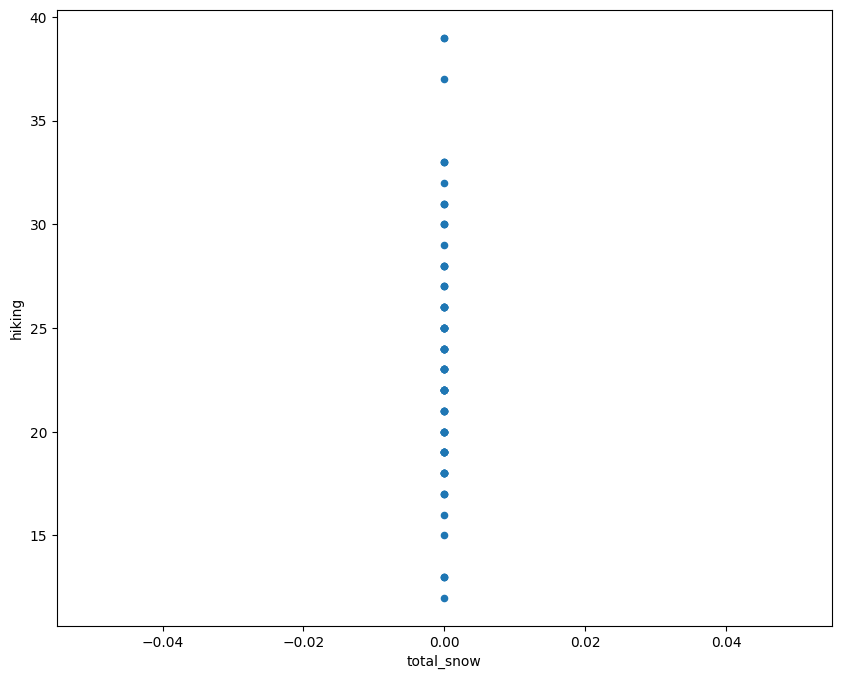

In [ ]:
merged_df.plot(x='total_snow', y=keywords[0], kind='scatter', figsize=(10, 8))

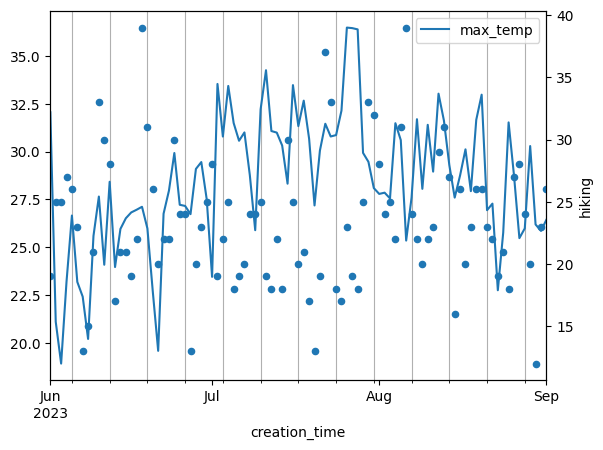

In [ ]:
#| export

fig,ax1 = plt.subplots()
ax2 = ax1.twinx()
merged_df.plot(x='creation_time', y='max_temp',ax=ax1)
merged_df.plot(x='creation_time', y=keywords[0], kind='scatter', ax=ax2)
#merged_df.plot(x='creation_time', y='weekday', kind='bar', ax=ax2,color='red')
ax1.grid(visible=True,axis='x',which='minor')


In [ ]:
#| export

import seaborn as sns

<seaborn.axisgrid.PairGrid>

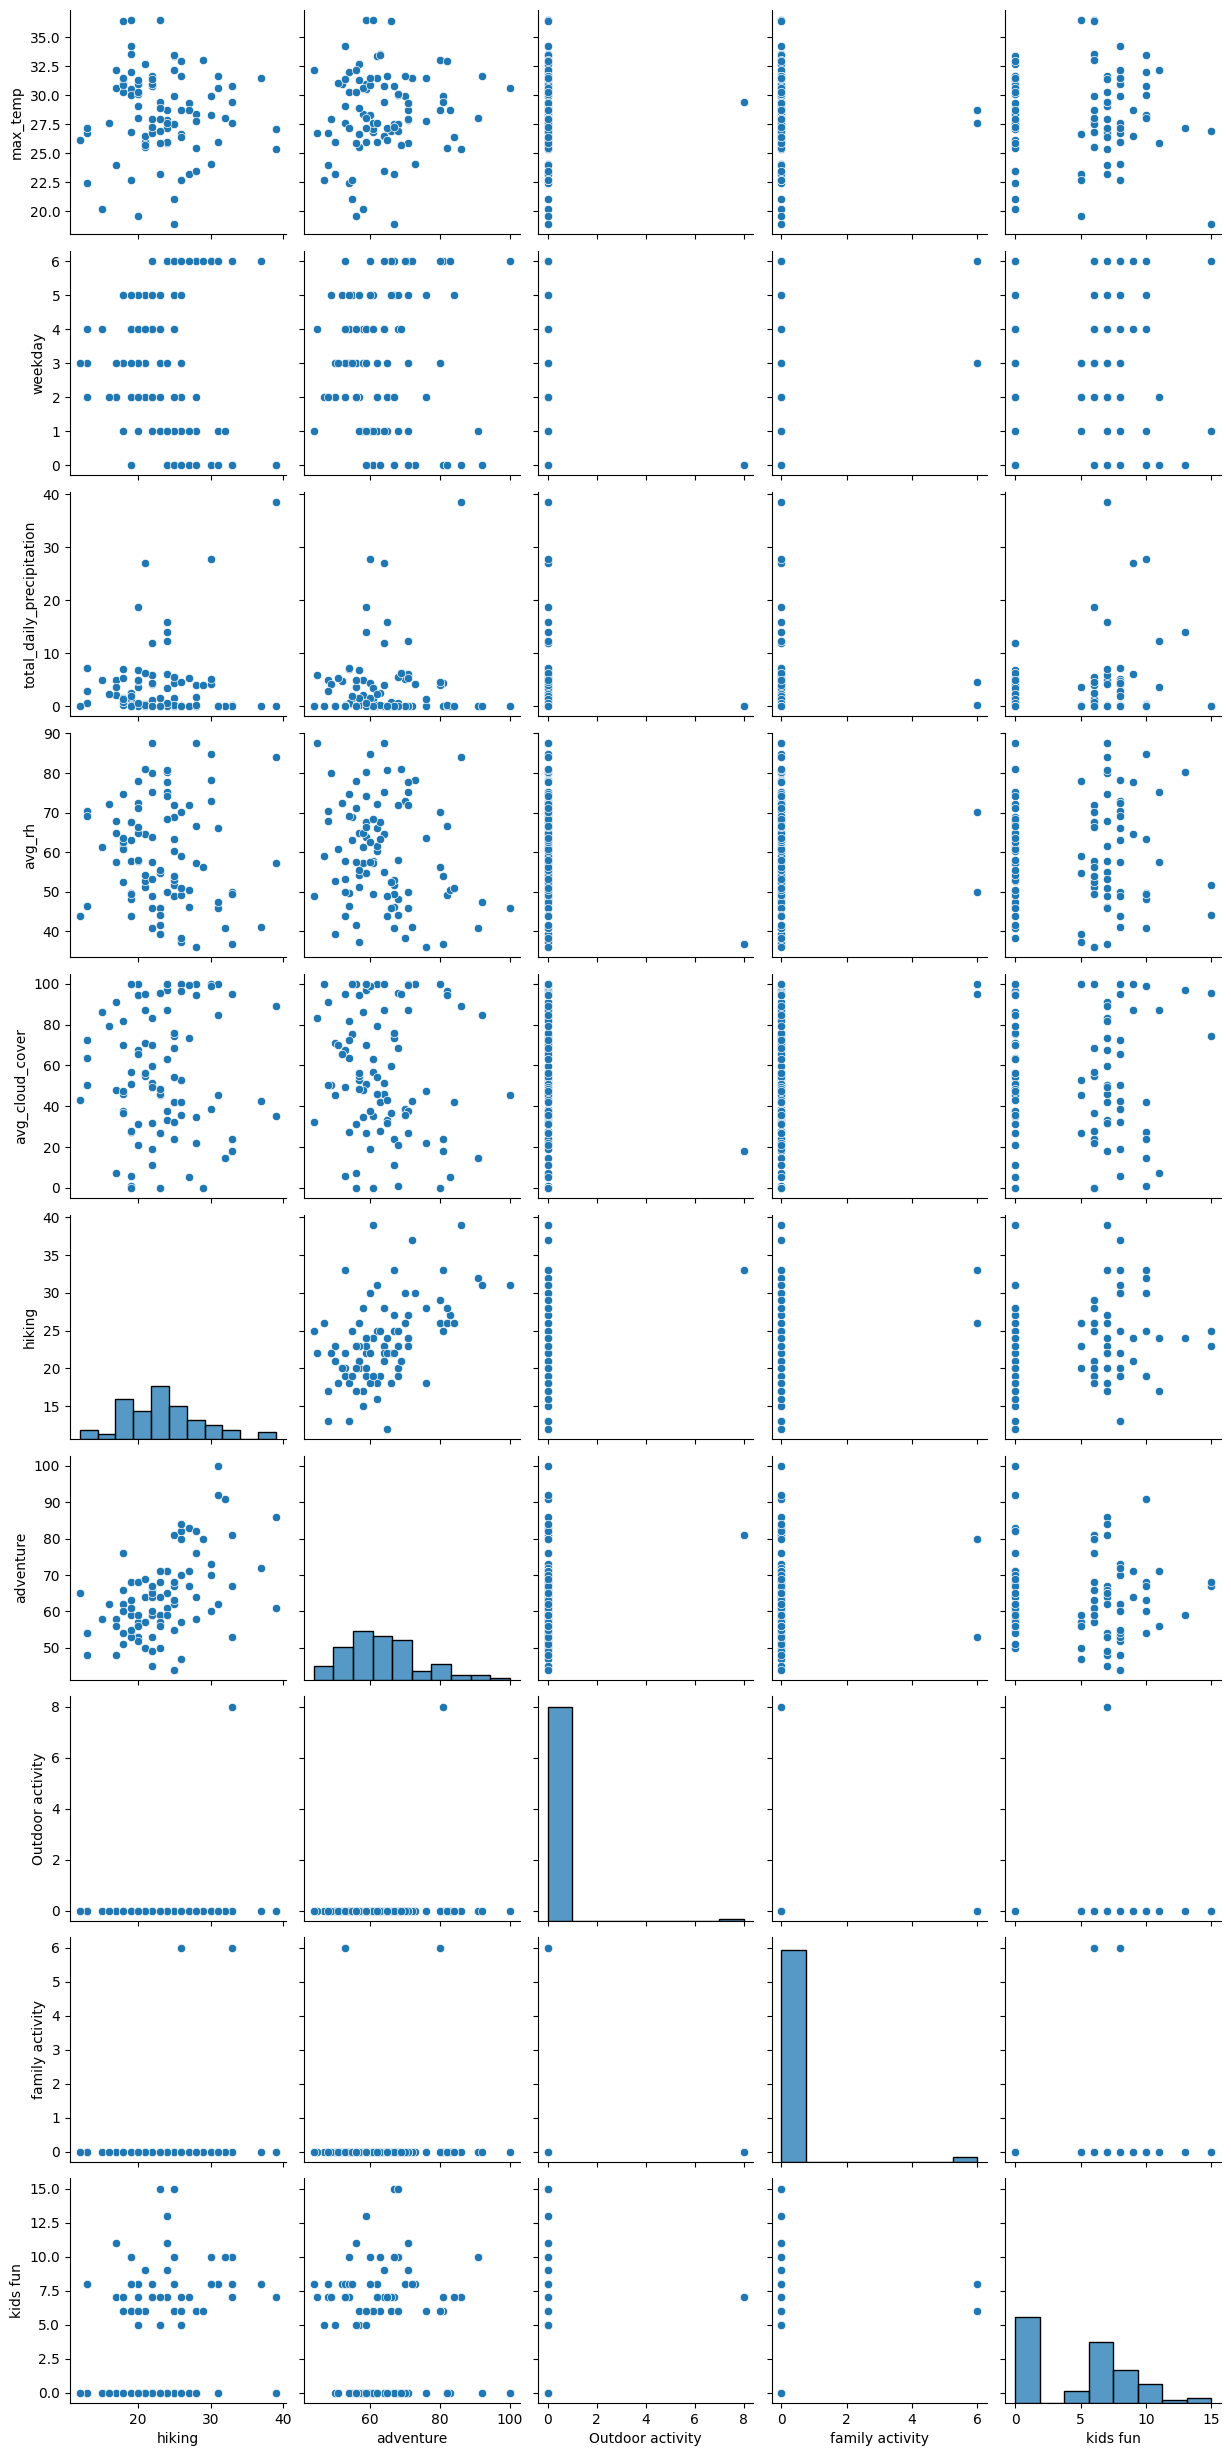

In [ ]:
#| export

sns.pairplot(merged_df[['max_temp','weekday','total_daily_precipitation','avg_rh', 'avg_cloud_cover']+keywords],x_vars=keywords)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()